### Rock Paper Scissor TRansfer Learning

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

In [0]:
dataset, info = tfds.load(name='rock_paper_scissors',as_supervised=True,with_info=True,split=['train','test'])

In [3]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

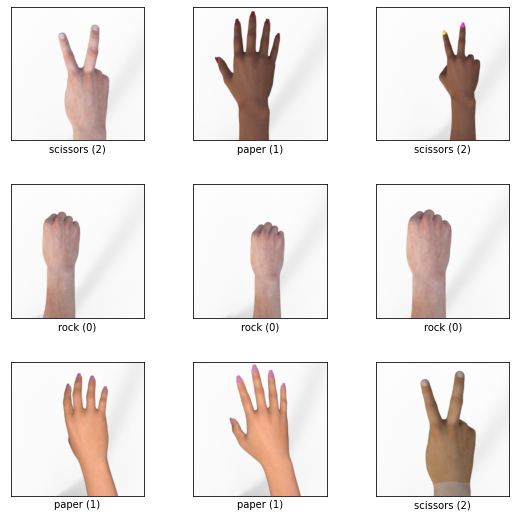

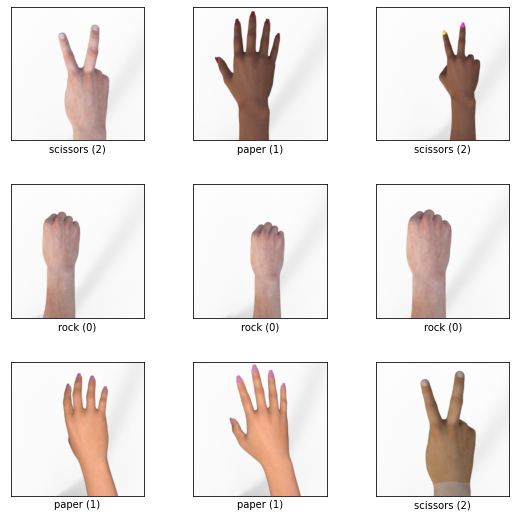

In [4]:
train, info_train = tfds.load(name='rock_paper_scissors',with_info=True,split='test')
tfds.show_examples(info_train, train)

In [0]:
dataset = dataset[0].concatenate(dataset[1])  #0:Train_set, 1:Test_ser
dataset = dataset.shuffle(3000)  #quick shuffling (random sampling)

In [0]:
#Spliting the dataset into, train, test and validation
rsp_validation = dataset.take(600)  
rsp_test_temp = dataset.skip(600)
rsp_test = rsp_test_temp.take(400)
rsp_train = rsp_test_temp.skip(400)

In [7]:
len(list(rsp_train))

1892

In [0]:
def scale(image,label):    #Scaling the images and resizing it from (300,300) to (224,224)
  image = tf.cast(image,tf.float64)
  image/=255.0

  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [0]:
def get_dataset(batch_size=64):
  train_scaled = rsp_train.map(scale).shuffle(1900).batch(batch_size)
  test_scaled = rsp_test.map(scale).batch(batch_size)
  validation_scaled = rsp_validation.map(scale).batch(batch_size)
  
  return train_scaled,test_scaled,validation_scaled

In [10]:
train_dataset, test_dataset, validation_dataset = get_dataset()
train_dataset.cache()
validation_dataset.cache()

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [0]:
#Pre-trained Model from tensorflow hub
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape = (224,224,3))

In [0]:
feature_extractor_layer.trainable=False

In [0]:
model = tf.keras.models.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3,activation='softmax')                           
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['acc'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc=[]
  
  def on_train_batch_end(self,batch,logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


In [17]:
train_dataset

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [18]:
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_dataset,epochs=2,validation_data=validation_dataset,callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
30/30 [==============================] - 11s 382ms/step - loss: 0.7908 - acc: 0.7778 - val_loss: 0.7023 - val_acc: 0.9600
Epoch 2/2
30/30 [==============================] - 10s 347ms/step - loss: 0.6626 - acc: 0.9444 - val_loss: 0.6161 - val_acc: 0.9733


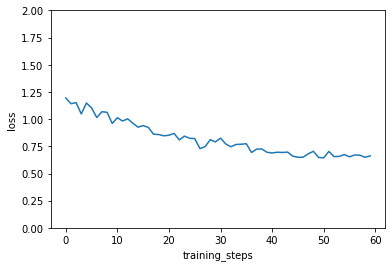

In [19]:
#Plotting loss graph
plt.figure()
plt.ylabel('loss')
plt.xlabel('training_steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

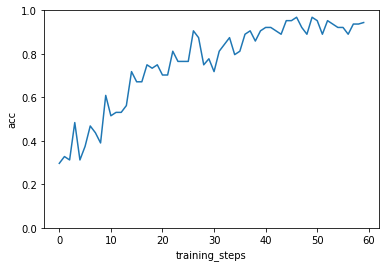

In [20]:
#Plotting loss graph
plt.figure()
plt.ylabel('acc')
plt.xlabel('training_steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [21]:
result = model.evaluate(test_dataset)

7/7 [==============================] - 1s 126ms/step - loss: 0.6143 - acc: 0.9775


[[0.01154533 0.0245898  0.9638648 ]]


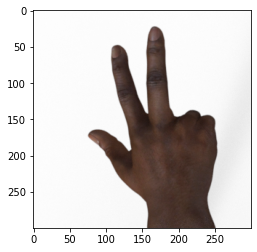

accuracy label: scissors
predicted label: scissors
[[0.92118824 0.06247339 0.01633841]]


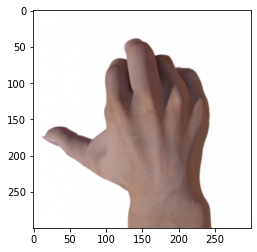

accuracy label: rock
predicted label: rock
[[0.97547317 0.02188663 0.00264009]]


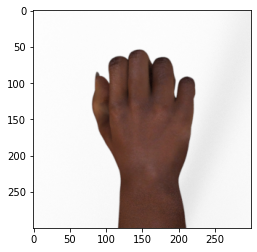

accuracy label: rock
predicted label: rock
[[0.9963013  0.00146469 0.00223405]]


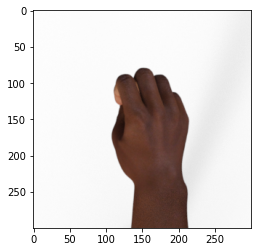

accuracy label: rock
predicted label: rock
[[0.98258305 0.01035178 0.00706525]]


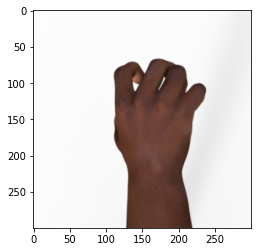

accuracy label: rock
predicted label: rock


In [22]:
for test_sample in rsp_test.take(5):
  image, label = test_sample[0],test_sample[1]
  image_scaled,label_arr=scale(test_sample[0],test_sample[1])
  image_scaled = np.expand_dims(image_scaled,axis=0)

  img = tf.keras.preprocessing.image.img_to_array(image)
  pred= model.predict(image_scaled)
  print(pred) 
  plt.figure()
  plt.imshow(image)
  plt.show()

  print('accuracy label: %s' % info.features['label'].names[label.numpy()])
  print('predicted label: %s' % info.features['label'].names[np.argmax(pred)])

In [23]:
np.argmax(model.predict(test_dataset),axis=1)

array([0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2,
       0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2,
       1, 2, 2, 0, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 2, 0, 1,
       2, 2, 0, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 0, 1, 2, 2, 0,
       0, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 1, 1, 0, 0,
       0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 2,
       2, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0,
       1, 1, 2, 2, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 2, 1, 0, 2, 0,
       2, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2, 1, 2,
       0, 1, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0,

In [24]:
for f0,f1 in rsp_test.map(scale).batch(400):
  y = np.argmax(f1,axis=1)
  y_pred = np.argmax(model.predict(f0),axis=1)

  print(tf.math.confusion_matrix(labels=y,predictions=y_pred,num_classes=3))

tf.Tensor(
[[116   0   0]
 [ 14 128   3]
 [  0   0 139]], shape=(3, 3), dtype=int32)


In [25]:
model.save('./models/',save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [26]:
!ls -alrt

total 20
drwxr-xr-x 1 root root 4096 Jun 10 16:28 sample_data
drwxr-xr-x 1 root root 4096 Jun 10 16:28 .config
drwxr-xr-x 1 root root 4096 Jun 12 14:00 ..
drwxr-xr-x 1 root root 4096 Jun 12 14:46 .
drwxr-xr-x 4 root root 4096 Jun 12 14:52 models


In [27]:
ls models

assets/  saved_model.pb  variables/


In [28]:
ls -alrt models

total 2280
drwxr-xr-x 1 root root    4096 Jun 12 14:46 ../
drwxr-xr-x 2 root root    4096 Jun 12 14:46 assets/
drwxr-xr-x 2 root root    4096 Jun 12 14:52 variables/
-rw-r--r-- 1 root root 2314339 Jun 12 14:52 saved_model.pb
drwxr-xr-x 4 root root    4096 Jun 12 14:52 ./


In [0]:
loaded_model = tf.keras.models.load_model('models')

[[2.5140475e-02 9.7429287e-01 5.6668045e-04]]


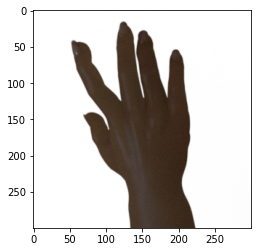

accuracy label: paper
predicted label: paper
[[9.9817729e-01 1.8048008e-03 1.7983415e-05]]


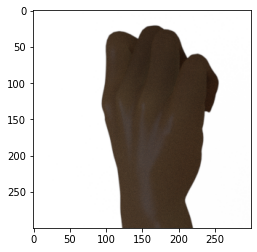

accuracy label: rock
predicted label: rock
[[0.0233925  0.02514928 0.95145816]]


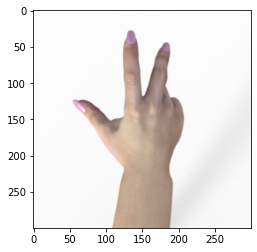

accuracy label: scissors
predicted label: scissors
[[9.86265123e-01 1.28451595e-02 8.89615214e-04]]


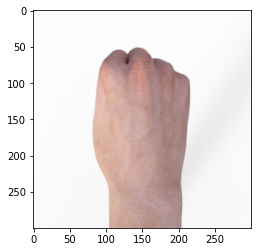

accuracy label: rock
predicted label: rock
[[0.00505456 0.22121578 0.7737296 ]]


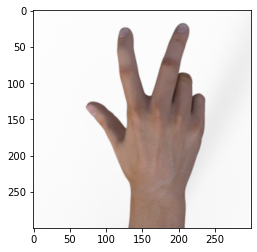

accuracy label: scissors
predicted label: scissors


In [30]:
for test_sample in rsp_test.take(5):
  image, label = test_sample[0],test_sample[1]
  image_scaled,label_arr=scale(test_sample[0],test_sample[1])
  image_scaled = np.expand_dims(image_scaled,axis=0)

  img = tf.keras.preprocessing.image.img_to_array(image)
  pred= model.predict(image_scaled)
  print(pred) 
  plt.figure()
  plt.imshow(image)
  plt.show()

  print('accuracy label: %s' % info.features['label'].names[label.numpy()])
  print('predicted label: %s' % info.features['label'].names[np.argmax(pred)])